In [1]:
import os
import re
import cv2
import tarfile
import datetime
import warnings
import prettytable
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow import concat
from tensorflow import repeat
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
warnings.filterwarnings('ignore')
from sklearn.utils import shuffle
from prettytable import PrettyTable
from skimage.transform import resize
import nltk.translate.bleu_score as bleu
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.backend import expand_dims 
from nltk.translate.bleu_score import sentence_bleu
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import concatenate, Concatenate
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.layers import Input, Softmax, RNN, Dense, Embedding, LSTM, Layer, Dropout, GRU

In [2]:
image_model = DenseNet121(weights='CheXNet_weights.h5', classes = 14, input_shape=(256,256,3))
model = Model(image_model.input, image_model.layers[-2].output)

In [3]:
model.save("CheXNet.keras")

In [4]:
train = np.load('train.npy',allow_pickle=True)
test = np.load('test.npy',allow_pickle=True)
validation = np.load('validation.npy',allow_pickle=True)

In [5]:
columns = ["front X-Ray", "lateral X-Ray", "findings", "dec_ip", "dec_op", "image_features"]

train = pd.DataFrame(train, columns = columns)
test = pd.DataFrame(test, columns = columns)
validation = pd.DataFrame(validation, columns = columns)

In [6]:
print("train data -     ",train.shape)
print('test data -      ',test.shape)
print('validation data -',validation.shape)

train data -      (3200, 6)
test data -       (399, 6)
validation data - (350, 6)


In [7]:
train.head()

,front X-Ray,lateral X-Ray,findings,dec_ip,dec_op,image_features
0,CXR677_IM-2249-2001.png,CXR677_IM-2249-1001.png,<start> picc line catheter tip in the right at...,<start> picc line catheter tip in the right at...,picc line catheter tip in the right atrium hea...,"[[1.3660428521689028e-05, 0.001198855228722095..."
1,CXR1096_IM-0066-2001.png,CXR1096_IM-0066-2001.png,<start> the heart size is within normal limits...,<start> the heart size is within normal limits...,the heart size is within normal limits no foca...,"[[0.00015775891370140016, 0.001071828184649348..."
2,CXR143_IM-0276-2001.png,CXR143_IM-0276-1001.png,<start> the lungs are clear no pleural effusio...,<start> the lungs are clear no pleural effusio...,the lungs are clear no pleural effusion is see...,"[[0.00012958170555066317, 0.001051775994710624..."
3,CXR3848_IM-1946-1001-0001.png,CXR3848_IM-1946-1001-0002.png,<start> the heart size is moderate to severely...,<start> the heart size is moderate to severely...,the heart size is moderate to severely enlarge...,"[[0.0003334000357426703, 0.0013413153355941176..."
4,CXR317_IM-1493-1001.png,CXR317_IM-1493-2001.png,<start> normal heart size normal mediastinal s...,<start> normal heart size normal mediastinal s...,normal heart size normal mediastinal silhouett...,"[[0.00026678695576265454, 0.001648269011639058..."


In [8]:
token = Tokenizer( filters='!"#$%&()*+,-/:;=?@[\\]^_`{|}~\t\n')
token.fit_on_texts(train['findings'].astype(str))

token.word_index['<pad>'] = 0
token.index_word[0] = '<pad>'
vocab_size = len(token.word_index) + 1
print('Vocab size - ', vocab_size)

#sequence in train and validation
train_inp_dec = token.texts_to_sequences(train.dec_ip)
train_op_dec = token.texts_to_sequences(train.dec_op)
val_inp_dec = token.texts_to_sequences(validation.dec_ip)
val_op_dec = token.texts_to_sequences(validation.dec_op)

#padding in the train and validation 
max_len = 100
decoder_input = pad_sequences(train_inp_dec, maxlen=max_len, padding='post')
decoder_output =  pad_sequences(train_op_dec, maxlen=max_len, padding='post') 
Validation_decoder_input = pad_sequences(val_inp_dec, maxlen=max_len, padding='post') 
Validation_decoder_output = pad_sequences(val_op_dec, maxlen=max_len, padding='post')
print(decoder_input[:1])

word_idx = {}
idx_word = {}
for key, value in (token.word_index).items(): 
    word_idx[key] = value
    idx_word[value] = key

Vocab size -  1465
[[  5 364 310 188 148  22   1  26 279  15   3 143  91 169   8 709  52   7
   16   4 114 242 102   2  12  13   4 103 117  11 192 161  22   1  30  79
   33  13   3  45 710 247  11 192 161  22   1  26 218   8  79  16  35  26
  170   9  14   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]]


In [9]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''
    def __init__(self,lstm_units):
        super().__init__()
        
        self.lstm_units = lstm_units
        self.dense      = Dense(self.lstm_units, kernel_initializer="glorot_uniform", name = 'encoder_dense_layer')
        
    def initialize_states(self,batch_size):
      
      self.batch_size  = batch_size
      self.enc_h       = tf.zeros((self.batch_size, self.lstm_units))
      
      return self.enc_h
    
    def call(self,x):
      
      # x : image_data
      encoder_output = self.dense(x)
      
      return encoder_output  

In [10]:
class Attention(tf.keras.layers.Layer):
  '''
    Class that calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,attention_units):
    super().__init__()

    self.attention_units = attention_units  

    self.w1_Dense    =  tf.keras.layers.Dense(self.attention_units, kernel_initializer="glorot_uniform", name='Concat_w1_Dense')
    self.w2_Dense    =  tf.keras.layers.Dense(self.attention_units, kernel_initializer="glorot_uniform", name='Concat_w2_Dense')
    self.Concat_Dense=  tf.keras.layers.Dense(1, kernel_initializer="glorot_uniform", name = 'Concat_Dense_layer')
  
  def call(self,x):
    
    self.decoder_hidden_state, self.encoder_output = x
    self.decoder_hidden_state = tf.expand_dims(self.decoder_hidden_state,axis = 1)
    
    score = self.Concat_Dense(tf.nn.tanh(self.w1_Dense(self.decoder_hidden_state) + self.w2_Dense(self.encoder_output)))
    
    att_weights    = tf.nn.softmax(score, axis=1)
    context_vector = att_weights * self.encoder_output
    context_vector = tf.reduce_sum(context_vector, axis=1)   
    
    return context_vector,att_weights

In [11]:
class OneStepDecoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, lstm_units, attention_units):
      super().__init__()
      
      self.lstm_units     = lstm_units
      self.vocab_size     = vocab_size
      self.embedding_dim  = embedding_dim
      self.attention_units= attention_units
      
      self.dense       = Dense(self.vocab_size, kernel_initializer="glorot_uniform", name ='onestep_dense')
      self.attention   = Attention( self.attention_units)
      self.decoder_emb = Embedding(self.vocab_size, self.embedding_dim, trainable = True , name = 'Decoder_embedding')           
      self.decoder_gru = GRU(self.lstm_units, return_state=True, return_sequences=True, name="Decoder_LSTM") 
      
      
      self.dropout1 = Dropout(0.3,name = 'dropout1')
      self.dropout2 = Dropout(0.3,name = 'dropout2')
      self.dropout3 = Dropout(0.3,name = 'dropout3')
      self.count = 0
  

  def call(self, x, training=None):
    self.count += 1
    
    self.input_to_decoder, self.encoder_output, self.state_h = x
    
    embedded_output = self.decoder_emb(self.input_to_decoder)
    
    embedded_output = self.dropout1(embedded_output)
      
    y = [self.state_h, self.encoder_output]
    context_vector, att_weights = self.attention(y)
    
    concated_decoder_input = tf.concat([tf.expand_dims(context_vector, 1), embedded_output], -1)
    
    concated_decoder_input = self.dropout2(concated_decoder_input)

    output_gru, hidden_state = self.decoder_gru(concated_decoder_input, initial_state=self.state_h)
    
    output_gru = tf.reshape(output_gru, (-1, output_gru.shape[2]))
    
    output_gru = self.dropout3(output_gru)
    
    output = self.dense(output_gru)
    
    temp = [output, hidden_state, att_weights, context_vector]
    
    return [output, hidden_state, att_weights, context_vector]


In [12]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, lstm_units, attention_units):
      super().__init__()

      self.lstm_units     = lstm_units
      self.vocab_size     = vocab_size
      self.embedding_dim  = embedding_dim
      self.attention_units= attention_units
      self.onestepdecoder = OneStepDecoder(self.vocab_size, self.embedding_dim, self.lstm_units, self.attention_units)

    @tf.function
    def call(self, x,training=None):
        self.input_to_decoder, self.encoder_output, self.decoder_hidden_state = x
        all_outputs = tf.TensorArray(tf.float32,size = self.input_to_decoder.shape[1], name = 'output_arrays' )
        for timestep in tf.range(self.input_to_decoder.shape[1]):
          y = [self.input_to_decoder[:,timestep:timestep+1],self.encoder_output, self.decoder_hidden_state]
          output,hidden_state,att_weights,context_vector = self.onestepdecoder(y)
          self.decoder_hidden_state = hidden_state
          all_outputs = all_outputs.write(timestep,output)
        all_outputs = tf.transpose(all_outputs.stack(),[1,0,2])
        return all_outputs

In [13]:
class Encoder_decoder(tf.keras.Model):
  """
     # Intialize encoder states, Pass the encoder_sequence to the embedding layer
     # Decoder initial states are encoder final states, Initialize it accordingly
     # Pass the decoder sequence,encoder_output,decoder states to Decoder
     # return the decoder output
  
  """ 
  def __init__(self, vocab_size, embedding_dim, lstm_units, attention_units, batch_size):
        super().__init__()

        self.vocab_size     = vocab_size
        self.batch_size     = batch_size
        self.lstm_units     = lstm_units
        self.embedding_dim  = embedding_dim
        self.attention_units= attention_units
        
        self.encoder = Encoder(self.lstm_units)
        self.decoder = Decoder(vocab_size, embedding_dim, lstm_units, attention_units)
        self.dense   = Dense(self.vocab_size, kernel_initializer="glorot_uniform", name = 'enc_dec_dense')


  
  def call(self,data):
    
    self.inputs, self.outputs = data[0], data[1]

    self.encoder_hidden = self.encoder.initialize_states(self.batch_size)
    self.encoder_output = self.encoder(self.inputs)
    
    x = [self.outputs,self.encoder_output,self.encoder_hidden]
    output = self.decoder(x)
    
    return output

In [14]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [15]:
lstm_units     = 256
batch_size     = 50
Buffer_size    = 500
embedding_dim  = 300
attention_units= 64

In [16]:
tf.keras.backend.clear_session()
#This will clear all tensorflow session
Attention_model = Encoder_decoder(vocab_size,embedding_dim,lstm_units,attention_units,batch_size)
Attention_model.compile(optimizer=tf.keras.optimizers.Adam(100.0),loss=loss_function)

In [17]:
%load_ext tensorboard


In [18]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience = 10, baseline=None, verbose = 1, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, mode = 'min',verbose = 1, patience=5, min_lr=0.000001)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [19]:
#Reshaping the Image tensors for training
train_image_features = np.vstack(train.image_features).astype(float)
validation_image_features = np.vstack(validation.image_features).astype(float)

In [20]:
train_dataset = tf.data.Dataset.from_tensor_slices(((train_image_features, decoder_input), decoder_output))
train_dataset = train_dataset.shuffle(Buffer_size).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices(((validation_image_features,Validation_decoder_input),Validation_decoder_output))
validation_dataset = validation_dataset.shuffle(Buffer_size).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [21]:
Attention_model.fit(train_dataset, validation_data=validation_dataset, epochs=5, callbacks=[early_stop,reduce_lr,tensorboard], shuffle=True)


Epoch 1/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 44s 604ms/step - loss: 1.9502 - val_loss: 2.0489 - learning_rate: 100.0000
Epoch 2/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 38s 599ms/step - loss: 1.9350 - val_loss: 2.0489 - learning_rate: 100.0000
Epoch 3/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 619ms/step - loss: 1.9267 - val_loss: 2.0489 - learning_rate: 100.0000
Epoch 4/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 42s 656ms/step - loss: 1.9394 - val_loss: 2.0489 - learning_rate: 100.0000
Epoch 5/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 648ms/step - loss: 1.9550 - val_loss: 2.0489 - learning_rate: 100.0000
Restoring model weights from the end of the best epoch: 1.


In [22]:
def load_image(img_name):
  """Loads image in array format"""

  image = Image.open(img_name)
  X = np.asarray(image.convert("RGB"))
  X = np.asarray(X)
  X = preprocess_input(X)
  X = resize(X, (256,256,3))
  X = np.expand_dims(X, axis=0)
  X = np.asarray(X)
    
  return X

In [23]:
def preprocess(image1_paths,image2_paths):

  '''
    input -- dataframe(df)
    output -- dataframe(df)
    process - convert images into 256 X 256, then using CHeXNET model generate tensor(concate two image tensor)
  
  '''
  path = 'images/'
  image_features = []
  for i in range(len(image1_paths)):

    i1 = load_image(path+image1_paths)
    i2 = load_image(path+image2_paths)
    img1_features = model.predict(i1)
    img2_features = model.predict(i2)
    img1_features = np.vstack(img1_features).astype(float)
    img2_features = np.vstack(img2_features).astype(float)
    
    tensor = np.concatenate((img1_features, img2_features), axis=1)

  return tensor

In [24]:
#Refrence : https://machinelearningmastery.com/beam-search-decoder-natural-language-processing/

def evaluate(image1, image2):
    '''
    Input - two image and image path
    output - return medical report of the images
    This function takes images and using encoder decoder model
    return medical report of the images
    The function predicts the sentence using beam search

    '''
    img_tensor     = preprocess(image1, image2)
    image_features = np.vstack(img_tensor).astype(float)

    result = ''
    initial_state = Attention_model.layers[0].initialize_states(1)
    sequences     = [['<start>', initial_state, 0]]

    encoder_output       = Attention_model.layers[0](image_features)
    decoder_hidden_state = initial_state

    max_len = 75
    beam_width = 3
    finished_seq = []

    for i in range(max_len):#traverse through all lengths
        new_seq = [] #stores the seq which does not have <end> in them
        all_probable = [] #stores all the top k seq along with their scores
        
        for seq,state,score in sequences: #traverse for all top k sequences
            
            cur_vec = np.reshape(word_idx[seq.split(" ")[-1]],(1,1)) 
            decoder_hidden_state = state
            x = [cur_vec, encoder_output, decoder_hidden_state]
            output,hidden_state,att_weights,context_vector = Attention_model.get_layer('decoder').onestepdecoder(x)
            output = tf.nn.softmax(output)
            top_words = np.argsort(output).flatten()[-beam_width:] #get the top k words
            for index in top_words:
                #here we will update score with log of probabilities and subtracting(log of prob will be in negative)
                #here since its -(log), lower the score higher the prob
                predicted = [seq + ' '+ idx_word[index], hidden_state, score-np.log(np.array(output).flatten()[index])] #updating the score and seq
                all_probable.append(predicted)

        sequences = sorted(all_probable, key = lambda l: l[2])[:beam_width] #getting the top 3 sentences with high prob ie low score
        
        count = 0 
        for seq,state,score in sequences: #check for 'endseq' in each seq in the beam
            if seq.split(" ")[-1] == '<end>': #if last word of the seq is <end>
                score = score/len(seq) #normalizing
                finished_seq.append([seq,state,score])
                count+=1
            else:
                new_seq.append([seq,state,score])
        
        sequences = new_seq
        beam_width= beam_width - count #substracting the no. of finished sentences from beam length
        
        if not sequences: #if all the sequences reaches its end
            break        
        else:
            continue

    if len(finished_seq) >0:
          finished_seq = sorted(finished_seq, reverse=True, key = lambda l: l[2]) # Reverse Sorted the Predicted output by score measure
          sequences = finished_seq[-1] #getting the last predicted output with least probablity score.
          k=0
          for i in finished_seq:
            k+=1
            print('Beam probablity-',i[2],'Candidate',k,':',i[0]) #printing top k predicted sentence by beam serch and their probablity score
          return sequences[0]
    else:
          return new_seq[-1][0]

In [25]:
def test_img_cap(img_data):
    
    '''
    input - imagedata point contain two x ray image and acutal medical report of the images
    output - function return two images and its original and predical medical report
    also return bleu score of the context
    
    '''
    path = 'images/'
    
    fig, axs = plt.subplots(1, 2, figsize = (10,10), tight_layout=True)
    count = 0
    for img, subplot in zip(img_data[:2], axs.flatten()):
        img_= mpimg.imread(path+img)
        imgplot = axs[count].imshow(img_, cmap = 'bone')
        count +=1
    plt.show()
    
    print('Acutal Report :', img_data[2])
    print('*'*200)
    result = evaluate(img_data[0],img_data[1])
    print('*'*200)
    print("Best Predicted:",result)
    print('BLEU Score :-',sentence_bleu(img_data[2], result),'\n')

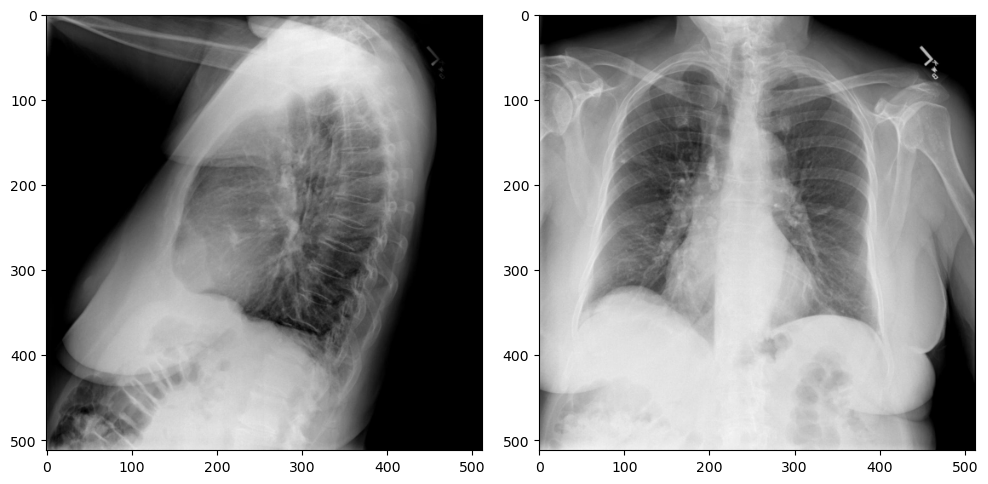

Acutal Report : <start> minimal opacities at the posterior sulci a few septal lines of the left lateral sulcus otherwise the lungs are clear with granulomas and sulci heart size upper normal thin lv contourunfolded calcified aorta t spine small osteophytes <end>
********************************************************************************************************************************************************************************************************
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125m

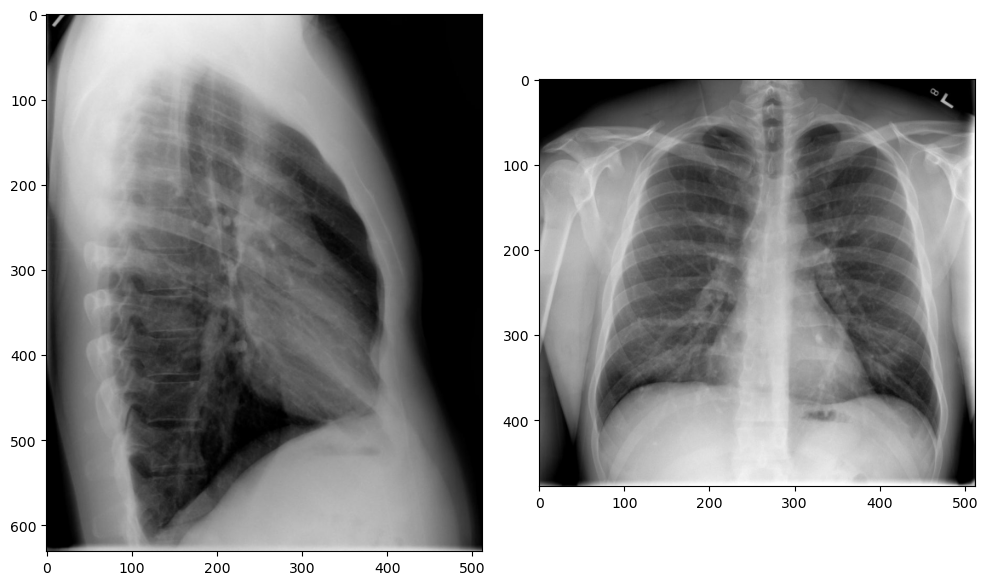

Acutal Report : <start> cardiac and mediastinal contours are within normal limits the lungs are clear bony structures are intact <end>
********************************************************************************************************************************************************************************************************
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1

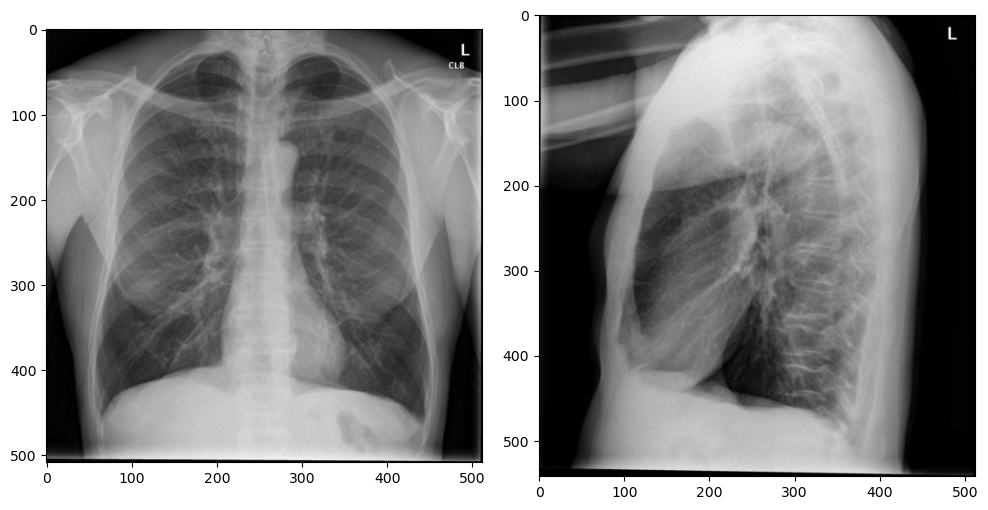

Acutal Report : <start> heart size and mediastinal contour within normal limits no focal airspace consolidation pneumothorax or large pleural effusion degenerative changes of thoracic spine <end>
********************************************************************************************************************************************************************************************************
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━

In [26]:
for i in test.values[17:20]:
    test_img_cap(i)